---
title: Optimising your New Year's sparkling purchase 
date: 2020-12-30  
comments: false  
tags: python
keywords: python, new years, sparkling wine, pareto optimisation, geopandas

---

We're all keen to say goodbye to this awful year, so I imagine most of you want to make the most of your New Year's celebration. While many of us won't be going anywhere, we can at least enjoy a good bottle of sparkling wine at home. In this blog post we'll use a dataset of around 1000 sparkling wines kindly scraped and posted to Kaggle by [Anton Budnyak](https://www.kaggle.com/budnyak/wine-rating-and-price?select=Sparkling.csv) to explore what is the best value bottle we can get for our money.

## Reading in and screening the data

We'll get started by loading in our dependencies and our data.

In [30]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import oapackage

from plotnine import *
from plotnine import ggplot, options
from mpl_toolkits.axes_grid1 import make_axes_locatable
from countryinfo import countries

wine_df = pd.read_csv("christmas_and_ny_2020/ny_data/Sparkling.csv")

Let's have a look at our available variables.

In [2]:
wine_df.columns

Index(['Name', 'Country', 'Region', 'Winery', 'Rating', 'NumberOfRatings',
       'Price', 'Year'],
      dtype='object')

Let's have a closer look at the country variable.

In [4]:
wine_df["Country"].value_counts()

France            398
Italy             375
Germany            78
Spain              70
South Africa       22
Austria            19
Luxembourg          9
Portugal            7
United States       7
Australia           5
Brazil              4
Moldova             4
New Zealand         4
United Kingdom      3
Chile               1
Slovenia            1
Name: Country, dtype: int64

We've got a good number of countries represented here, although the distribution is quite skewed. Let's get started by visualising the ratings and prices of wines by country. We can do this by downloading a shapefile to represent the map we want (in this case the [entire world](https://hub.arcgis.com/datasets/a21fdb46d23e4ef896f31475217cbb08_1)) and plotting our variables of interest using `geopandas`. See [here](ttps://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d) and [here](https://geopandas.org/mapping.html) for more details on how to do this.

We'll start by loading in our map dataframes, and removing Antarctica to make the map display a little nicer.

In [48]:
world_map_path = "/Users/jodieburchell/Documents/cristian-data-assignment/data/Longitude_Graticules_and_World_Countries_Boundaries-shp/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"
world_map_df = gpd.read_file(world_map_path)
world_map_df = world_map_df[world_map_df["CNTRY_NAME"] != "Antarctica"]

Now we'll create a dataset which contains only the median rating and price of the wines by country, and merge it with our map dataframe. We'll only keep those countries with at least 4 wines in the dataset.

In [49]:
rating_median = wine_df[["Country", "Rating"]].groupby("Country").median().reset_index()
price_median = wine_df[["Country", "Price"]].groupby("Country").median().reset_index()
median_df = pd.merge(rating_median, price_median, on = "Country")
# Remove countries with < 4 wines
median_df = median_df[~(median_df["Country"].isin(["United Kingdom", "Slovenia", "Chile"]))]

wine_world_df = (world_map_df.set_index("CNTRY_NAME")
                 .join(median_df.set_index("Country"), how = "left"))

## Making our maps

We'll now write a function to create our map. I won't go into all of the customisation options I used here, but all of them are described in the two links I included about `geopandas` above.

In [65]:
def create_map(df: gpd.GeoDataFrame, 
               column: str, 
               title: str, 
               legend_label: str, 
               vmin: float, 
               vmax: float) -> None:

    fig, ax = plt.subplots(1, figsize = (14, 10))
    ax.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size = "5%", pad = 0.2)

    ax.set_title(title, fontdict = {"fontsize": "22", "fontweight": "3"})

    df.plot(column = column,
            cmap = "viridis",
            ax = ax,
            legend = True,
            vmin = vmin,
            vmax = vmax,
            missing_kwds = {"color": 'lightgrey'},
            legend_kwds = {"label": legend_label,
                           "orientation": "horizontal"},
            cax=cax)

We'll start by visualising the median ratings of the wines per country:

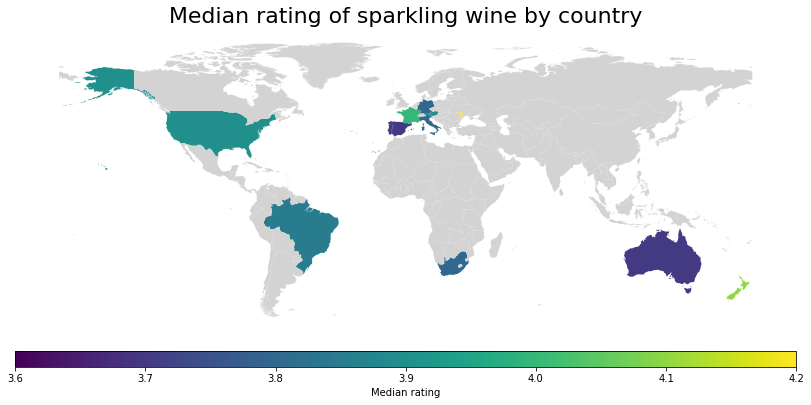

In [66]:
m1 = create_map(wine_world_df, "Rating", "Median rating of sparkling wine by country",
           "Median rating", 3.6, 4.2)

Unfortunately my home country of Australia doesn't seem to be rating so well, but our neighbouring New Zealand is. A few European countries seem to produce well rated wines as well, including France (of course) and, interestingly, Moldova. 

But how much will this well-rated wine cost you? Let's now visualise the median cost per bottle:

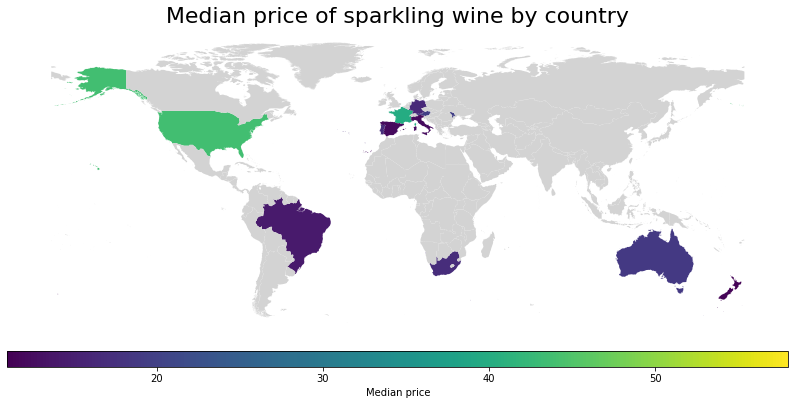

In [67]:
create_map(wine_world_df, "Price", "Median price of sparkling wine by country",
           "Median price", 11, 58)

While France seemed to have some of the best rated wines, they are also among some of the most expensive as well. Moldova's and New Zealand's wines seem to be cheaper, falling below the \$20 per bottle mark.

These visualisations give us a rough idea of which regions can give us our best bang for our buck, but can we take a more systematic approach to finding the best tradeoff between rating and price?

## Using Pareto optimisation

We can solve for this relatively simply using a economic algorithm called [Pareto optimality](https://en.wikipedia.org/wiki/Pareto_efficiency) (or Pareto efficiency). This algorithm takes multiple objectives (in our case, rating and price) and tries to find those combinations for which we cannot achieve a better outcome. These combinations lie on the [Pareto front](https://pythonhealthcare.org/tag/pareto-front/), which is that part of a graph between the two objectives for which no better combination exists. You can see this clearly in the example below, where the Pareto front includes all those combinations that maximise both Objective A and Objective B across the entire x- and y-axes.

[Insert image here]

To make my life easier, I found a [package](https://oapackage.readthedocs.io/en/latest/examples/example_pareto.html) called `oapackage` in Python which includes a module to calculate Pareto-optimised combinations. We'll use it to find out the best sparkling wines we can get across a range of different budgets.

To start, we'll create a variable which reverses the price field. We want to do this because we want to optimise for the lowest price, rather than the highest.

In [54]:
wine_df["Price_reversed"] = wine_df["Price"].max() - wine_df["Price"]

We then convert our columns into a numpy array.

In [55]:
wine_vars = list()

wine_vars.append(wine_df["Rating"].to_list())
wine_vars.append(wine_df["Price_reversed"].to_list())
wine_vars = np.array(wine_vars)

Using this, we then turn each pair of rating and reversed price into a 2-dimensional vector and then convert these into a `ParetoDoubleLong` so that the package can perform the Pareto optimisation.

In [56]:
pareto = oapackage.ParetoDoubleLong()

for i in range(0, wine_vars.shape[1]):
    w = oapackage.doubleVector((wine_vars[0, i], wine_vars[1, i]))
    pareto.addvalue(w, i)

Finally, we get the values of our Pareto-optimised pairs. Wasn't that easy?

In [57]:
lst = pareto.allindices()
optimal_datapoints=wine_vars[:,lst]
optimal_datapoints

array([[  4.4 ,   4.2 ,   4.3 ,   4.6 ,   4.5 ,   4.7 ],
       [467.  , 491.85, 484.58, 376.  , 406.1 , 131.25]])

However, these values alone are not that useful without the names and descriptions of the wines. We'll do a bit of data wrangling to merge our Pareto-optimised values with the rest of our dataset.

In [58]:
p_opt = pd.DataFrame({"Rating": optimal_datapoints[0], 
                      "Price_reversed": optimal_datapoints[1],
                      "Pareto_classification": "Pareto optimal"
                     })

optimised_df = pd.merge(wine_df, p_opt, 
                        on = ["Rating", "Price_reversed"], 
                        how = "left").fillna("Non-Pareto optimal")

We now have a dataset that contains a field differentiating those wines that are Pareto-optimal (i.e., our best tradeoff between price and rating). Let's start by plotting these against the rest of the dataset. Note that I used the original price field in the plot, but reversed it so you can clearly see the Pareto front.

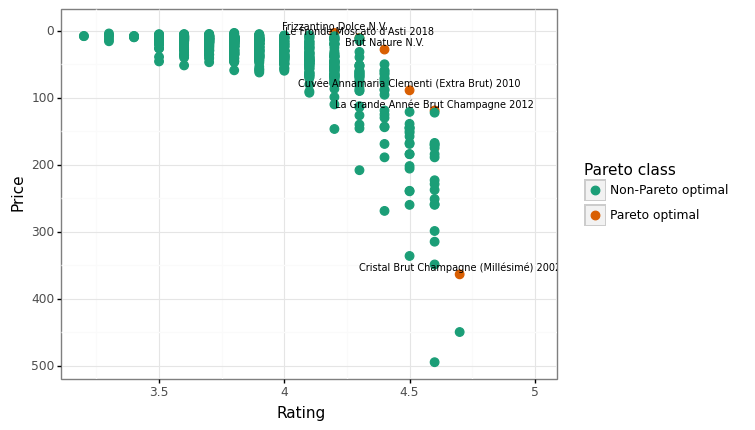

<ggplot: (319297949)>

In [59]:
p = (ggplot(optimised_df, aes("Rating", "Price", colour = "Pareto_classification")) 
 + geom_point(size = 3)
 + scale_x_continuous(limits = [3.2, 5])
 + scale_y_continuous(trans = "reverse") 
 + geom_text(aes(x='Rating', y='Price', label='Name'),
             color="black",
             size = 7,
             data=optimised_df[optimised_df["Pareto_classification"] == "Pareto optimal"],
             nudge_y = 10)
 + theme_bw()
 + scale_color_brewer(type = "qual", palette = "Dark2", name = "Pareto class")
)
p

Now let's have a closer look at what wines our Pareto optimisation recommends:

In [60]:
optimised_df.loc[optimised_df["Pareto_classification"] == "Pareto optimal", 
             ["Name", "Year", "Country", "Region", "Winery", "Rating", "Price"]].sort_values("Price")

,Name,Year,Country,Region,Winery,Rating,Price
100,Frizzantino Dolce N.V.,N.V.,Italy,Emilia,Gualtieri,4.2,3.15
276,Le Fronde Moscato d'Asti 2018,2018,Italy,Moscato d'Asti,Fontanafredda,4.3,10.42
72,Brut Nature N.V.,N.V.,Germany,Pfalz,Frank John,4.4,28.00
441,Cuvée Annamaria Clementi (Extra Brut) 2010,2010,Italy,Franciacorta,Ca' del Bosco,4.5,88.90
424,La Grande Année Brut Champagne 2012,2012,France,Champagne,Bollinger,4.6,119.00
892,Cristal Brut Champagne (Millésimé) 2002,2002,France,Champagne,Louis Roederer,4.7,363.75


On the cheapest end, we have a very well-rated Italian sparkling wine, the Frizzantino Dolce N.V., coming in at a bargain \$3.15. On the other end we have the predictable champagnes: Bollinger La Grande Année Brut Champagne 2012 at \$119 and Louis Roederer Cristal Brut Champagne (Millésimé) 2002 at an eye-watering \$363.75. Interestingly, none of the New Zealand or Moldovian wines turned up in this list, suggesting that while the overall ratings for Germany and Italian wines are not as high as for New Zealand or Moldova, their best wines outshine their New Zealand and Moldovian counterparts. The sample size for the New Zealand and Moldovian wines was also really small, meaning we can't be sure if the wines from those countries are representative or a lucky pick of really good examples.

So what is the takeaway recommendation based on this analysis? If you can't get your hands on one of the top wines found by the Pareto optimisation, you're better off going for something from France, New Zealand or Moldova (assuming our tiny sample is representative). Have a wonderful New Year's celebration, stay safe, and here's hoping for a better 2021!